In [1]:
from dask.distributed import Client, LocalCluster
import bokeh
import geopandas as gpd
import scipy
import libpysal
import momepy
import json
from dask import delayed
import glob
import dask
import dask.dataframe as dd
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import json
from tqdm import tqdm
from shapely.geometry import Point
import networkx as nx
import pickle

/tmp/ipykernel_10897/3967175050.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
local_crs = 3414

place = "singapore"

In [3]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40413 instead
  warnings.warn(
2023-05-23 19:30:21,455 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-05-23 19:30:21,457 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-05-23 19:30:21,458 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-05-23 19:30:21,461 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-05-23 19:30:21,463 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-05-23 19:30:21,466 - distributed.nanny.memory - WARNING - Ignoring

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40413/status,
Dashboard: http://127.0.0.1:40413/status,Workers: 8
Total threads: 8,Total memory: 250.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46363,Workers: 8
Dashboard: http://127.0.0.1:40413/status,Total threads: 8
Started: Just now,Total memory: 250.47 GiB
Comm: tcp://127.0.0.1:39923,Total threads: 1
Dashboard: http://127.0.0.1:33163/status,Memory: 31.31 GiB
Nanny: tcp://127.0.0.1:42425,


In [ ]:
# with open('./out/{place}/what_cells_are_in_what_cluster_dict.json', 'r') as f:
#     includes_dict = json.load(f)
    
tessellation = gpd.read_parquet(f"./out/{place}/tessellation.pq")

buildings = gpd.read_parquet(f"./out/{place}/buildings.pq")

streets = gpd.read_parquet(f"./out/{place}/streets.pq").explode()

In [ ]:
streets['nID'] = momepy.unique_id(streets)
# buildings['nID'] = momepy.get_network_id(buildings, streets,
#                                                'nID').values

# buildings = buildings.drop_duplicates("uID").drop(columns="index_right")
# tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

In [ ]:
# @dask.delayed
# def queen_contiguity_load(n1, includes_dict):
#     chunk = gpd.read_parquet(f"./out/{place}/expanded_cells_in_chunk_{int(n1)}.pq")
    
#     # weights
    # queen_1 = libpysal.weights.w_subset(momepy.sw_high(k=1, gdf=chunk, ids='uID'), includes_dict[str(n1)]).to_adjlist()
    # queen_3 = libpysal.weights.w_subset(momepy.sw_high(k=3, gdf=chunk, ids='uID'), includes_dict[str(n1)]).to_adjlist()
    
#     return (queen_1, queen_3)

In [ ]:
# file_pattern = f"./out/{place}/expanded_cells_in_chunk_*.pq"
# file_list = glob.glob(file_pattern)
# num_files = len(file_list)

# weight_out = [process(n1, includes_dict) for n1 in tqdm(range(num_files))]

# weight_out = [queen_contiguity_load(n1, includes_dict) for n1 in range(num_files)]

# weight_out = dask.compute(weight_out)


In [ ]:
# queen_1 = libpysal.weights.W.from_adjlist(pd.concat(weight_out[0][i][0] for i in range(num_files)))

# queen_3 = libpysal.weights.W.from_adjlist(pd.concat(weight_out[0][i][1] for i in range(num_files)))

In [26]:
queen_1 = libpysal.weights.fuzzy_contiguity(tessellation, tolerance=0.05, buffering=True, drop=True, buffer=20, ids="uID", silence_warnings=True)
queen_3 = momepy.sw_high(k=3, weights=queen_1)
dist200 = libpysal.weights.DistanceBand.from_dataframe(buildings, 200, ids='uID')

KeyboardInterrupt: 

In [ ]:
# # Find the uIDs in tessellation that are not in buildings
# tessellation_uids = set(tessellation['uID'])
# buildings_uids = set(buildings['uID'])
# new_uids = tessellation_uids - buildings_uids

# # Create a new GeoDataFrame with the new uIDs and empty geometry
# new_rows = pd.DataFrame({'uID': list(new_uids)})
# new_rows['geometry'] = None
# new_gdf = gpd.GeoDataFrame(new_rows, crs=buildings.crs)

# # Append the new GeoDataFrame to buildings
# new_buildings = pd.concat([buildings, new_gdf], ignore_index=True)

In [ ]:
### Building Area
buildings['building_area'] = momepy.Area(buildings).series
tessellation['tess_area'] = momepy.Area(tessellation).series

In [ ]:
buildings_future = buildings
streets_future = streets
# tessellation_future = tessellation
# queen_3_future = queen_3

In [ ]:
# # buildings_future = client.scatter(buildings)
# # streets_future = client.scatter(streets)
# tessellation_future = client.scatter(tessellation)
# queen_3_future = client.scatter(queen_3)

In [ ]:
buildings_future = client.scatter(buildings)
streets_future = client.scatter(streets)
tessellation_future = client.scatter(tessellation)
queen_3_future = client.scatter(queen_3)

In [ ]:
computations = []
### Circular Compactness
building_circular_compactness =  delayed(momepy.CircularCompactness)(buildings_future)
computations.append(building_circular_compactness)

### Elongation
building_elongation = delayed(momepy.Elongation)(buildings_future)
computations.append(building_elongation)

## Squareness
building_squareness = delayed(momepy.Squareness)(buildings_future)
computations.append(building_squareness)

building_eri = delayed(momepy.EquivalentRectangularIndex)(buildings_future)
computations.append(building_eri)

street_linearity = delayed(momepy.Linearity)(buildings_future)
computations.append(street_linearity)

# StreetProfile computation
profile = delayed(momepy.StreetProfile)(streets_future, buildings_future)
computations.append(profile)

# Tessellation computations
tess_convexity = delayed(momepy.Convexity)(tessellation_future)
computations.append(tess_convexity)

tess_neighbours = delayed(momepy.Neighbors)(tessellation_future, queen_3_future,'uID', weighted=True)
computations.append(tess_neighbours)

tess_neighbours_200 = delayed(momepy.Neighbors)(tessellation_future, dist200, 'uID', weighted=True)
computations.append(tess_neighbours_200)

tess_covered_area = delayed(momepy.CoveredArea)(tessellation_future, queen_1, "uID")
computations.append(tess_covered_area)

tess_area_iqr = delayed(momepy.Range)(
    tessellation_future, values='tess_area', spatial_weights=queen_3_future, unique_id='uID', rng=(25, 75))
computations.append(tess_area_iqr)

tess_rea_theil = delayed(momepy.Theil)(
    tessellation_future, values='tess_area', spatial_weights=queen_3_future, unique_id='uID')
computations.append(tess_rea_theil)

building_orientation = delayed(momepy.Orientation)(buildings_future)
computations.append(building_orientation)

tess_orientation = delayed(momepy.Orientation)(tessellation_future)
computations.append(tess_orientation)

building_neighbour_dist = delayed(momepy.NeighborDistance)(buildings_future, queen_1, 'uID')
computations.append(building_neighbour_dist)

building_neighbourhood_interbuilding_distance = delayed(momepy.MeanInterbuildingDistance)(buildings_future, queen_1, 'uID', 3)
computations.append(building_neighbourhood_interbuilding_distance)

In [ ]:
# Compute all tasks at once using the Dask client
results = client.compute(computations)

In [ ]:
building_circular_compactness, building_elongation, building_squareness, building_eri, street_linearity, profile, tess_convexity, tess_neighbours, tess_neighbours_200, tess_covered_area, tess_area_iqr, tess_rea_theil, building_orientation, tess_orientation, building_neighbour_dist, building_neighbourhood_interbuilding_distance = results

In [ ]:
buildings['building_circular_compactness'] = building_circular_compactness.result().series
buildings['building_elongation'] = building_elongation.result().series
buildings['building_squareness'] = building_squareness.result().series
buildings['building_eri'] = building_eri.result().series
buildings['building_orientation'] = building_orientation.result().series
streets['street_linearity'] = street_linearity.result().series
tessellation["tess_convexity"] = tess_convexity.result().series
tessellation["tess_neighbours"] = tess_neighbours.result().series
tessellation["tess_neighbours_200"] =  tess_neighbours_200.result().series
tessellation["tess_covered_area"] = tess_covered_area.result().series
tessellation["tess_area_iqr"] = tess_area_iqr.result().series
tessellation["tess_rea_theil"] = tess_rea_theil.result().series
buildings["building_orientation"] = building_orientation.result().series
tessellation["tess_orientation"] = tess_orientation.result().series
tessellation["building_neighbour_dist"] = building_neighbour_dist.result().series
tessellation["building_neighbourhood_interbuilding_distance"] = building_neighbourhood_interbuilding_distance.result().series

In [ ]:
profile_result = profile.result()


streets["street_width"] = profile_result.w
streets["street_width_deviation"] = profile_result.wd
streets["street_openness"] = profile_result.o

In [ ]:
buildings['building_weighted_circom'] = momepy.WeightedCharacter(
buildings, buildings["building_circular_compactness"], queen_3, 'uID', momepy.Area(buildings).series).series

In [ ]:
# primal = momepy.gdf_to_nx(streets, approach='primal')

In [ ]:
%%time
# momepy.node_degree(primal)

In [ ]:
%%time
# primal = momepy.closeness_centrality(primal, radius=400, name='closeness400', distance='mm_len', weight='mm_len')

In [ ]:
%%time
# primal = momepy.meshedness(primal, radius=400, distance="mm_len")

In [ ]:
# %%time
# primal = momepy.straightness_centrality(primal)

In [ ]:
# %%time
# primal = momepy.closeness_centrality(primal, name='closeness_global', weight='mm_len')

In [ ]:
# %%time
# primal =  momepy.betweenness_centrality(primal, name='betweenness_metric_n', mode='nodes', weight='mm_len', k=100)

In [ ]:
# %%time
# primal = momepy.straightness_centrality(primal)
# # momepy.mean_nodes(primal, 'straightness')
# momepy.mean_nodes(primal, 'closeness400')
# # momepy.mean_nodes(primal, 'closeness_global')
# # momepy.mean_nodes(primal, 'betweenness_metric_n')

# nodes, streets = momepy.nx_to_gdf(primal)

In [ ]:
# dual = momepy.gdf_to_nx(streets, approach='dual')

# dual = momepy.closeness_centrality(dual, radius=5, name='angcloseness400', weight='angle')

# # dual = momepy.closeness_centrality(dual, name='closeness_global_ang', weight='angle')

# # dual = momepy.betweenness_centrality(dual, name='angbetweenness', mode='nodes', weight='angle')

# edges_d = momepy.nx_to_gdf(dual)


In [ ]:
cols = list(streets.columns)
cols.remove('geometry')

In [ ]:
streets_dropped = streets.drop(cols,axis=1).reset_index(drop=True)

In [ ]:
buildings = buildings.set_crs(local_crs)

In [ ]:
# buildings=buildings.drop(["index_right"], axis=1)

In [ ]:
buildings=buildings.drop(["uID_left", "index_right", "uID_right"], axis=1)

In [ ]:
tessellation=tessellation.drop(["uID_left", "index_right", "uID_right"], axis=1)

In [ ]:
buildings = gpd.sjoin_nearest(left_df=buildings, right_df=streets_dropped, how='left', max_distance=1000).drop_duplicates(subset=['geometry'])
duplicates = buildings[buildings.duplicated(['uID'], keep=False)]
if len(duplicates) > 0:
    print(f"There are {len(duplicates)} rows with duplicate uids.")
    print(duplicates)
else:
    print("There are no rows with duplicate uids.")


In [ ]:
buildings = buildings.dropna(subset=['geometry'])
tessellation = tessellation.dropna(subset=['geometry'])

In [ ]:
streets.reset_index(drop=True, inplace=True)

In [ ]:
streets["nID"]= streets.index

In [ ]:
buildings.drop(columns=['index_right'], inplace=True)

In [ ]:
streets["nID"]= streets.index
buildings =  gpd.sjoin_nearest(buildings, streets, how="left", max_distance=1000)

In [ ]:
buildings["building_str_align"] = momepy.StreetAlignment(buildings, streets,
                                   'building_orientation', 'nID',
                                   'nID').series

In [ ]:
blg_cell_align = momepy.CellAlignment(buildings, tessellation,
                                      'building_orientation', 'tess_orientation',
                                      'uID', 'uID')
buildings['building_cell_align'] = blg_cell_align.series

In [ ]:
tessellation['tess_car'] = momepy.AreaRatio(tessellation, buildings, 'tess_area', 'building_area', 'uID').series

In [ ]:
nodes = gpd.read_parquet(f"./out/{place}/vertices_frame.pq")
edges = gpd.read_parquet(f"./out/{place}/edges_frame.pq")

In [ ]:
buildings = buildings.drop(["nID", "index_right", "nID"], axis=1)
nodes = nodes.drop(["vertID"], axis=1)
edges = edges.drop("edgeID", axis=1)

In [ ]:
buildings = gpd.sjoin_nearest(left_df=buildings, right_df=nodes, how='left', max_distance=1000).drop_duplicates(subset=['geometry'])
duplicates = buildings[buildings.duplicated(['uID'], keep=False)]
if len(duplicates) > 0:
    print(f"There are {len(duplicates)} rows with duplicate uids.")
    print(duplicates)
else:
    print("There are no rows with duplicate uids.")


In [ ]:
buildings = buildings.drop("index_right", axis=1)
buildings = gpd.sjoin_nearest(left_df=buildings, right_df=edges, how='left', max_distance=1000).drop_duplicates(subset=['geometry'])
duplicates = buildings[buildings.duplicated(['uID'], keep=False)]
if len(duplicates) > 0:
    print(f"There are {len(duplicates)} rows with duplicate uids.")
    print(duplicates)
else:
    print("There are no rows with duplicate uids.")


In [ ]:
tessellation = tessellation.merge(buildings, how='left', left_on = "uID", right_on="uID" )

In [ ]:
tessellation = tessellation.drop(["geometry_y", "index_right"], axis=1)
tessellation = tessellation.rename(columns={"geometry_x": "geometry"})
tessellation = gpd.GeoDataFrame(tessellation.dropna(subset=['geometry']))

In [ ]:
with open(f"./out/{place}/weights.pickle", 'wb') as f:
    pickle.dump(queen_1, f)
    pickle.dump(queen_3, f)
    pickle.dump(dist200, f)
    f.close()

In [ ]:
tessellation.columns=tessellation.columns.astype(str)

In [ ]:
tessellation

In [ ]:
tessellation.describe()

In [ ]:
tessellation.to_parquet(f"./out/{place}/tessellation_stats_no_percentile.pq")

In [ ]:
# def split_dataframe(df, num_dfs):
#     """
#     This function splits a DataFrame into a list of smaller DataFrames with equal number of columns.

#     Parameters:
#     df (pandas.DataFrame): The DataFrame to split.
#     num_dfs (int): The number of DataFrames to split 'df' into.

#     Returns:
#     list: A list of pandas DataFrame objects.
#     """

#     dfs = []
#     n = df.shape[1]
#     num_cols = n // num_dfs

#     for i in range(num_dfs):
#         start = i * num_cols
#         end = (i + 1) * num_cols if i != num_dfs - 1 else n
#         dfs.append(df.iloc[:, start:end])

#     return dfs

# # Use the function
# list_of_dfs = split_dataframe(tessellation[tessellation.columns.drop(["uID", "geometry"])], 16)

In [ ]:
tessellation_future = client.scatter(tessellation)

In [15]:
dropped = tessellation.drop(["uID", "geometry"], axis=1)

column_lists = [list(dropped.columns[i:i + 16]) 
                for i in range(0, len(dropped.columns), 16)]



In [23]:
# def process_percentiles(tessellation, queen_3):
#     percentiles = []
#     for column in tessellation.columns.drop(["uID", "geometry"]):
#         perc = momepy.Percentiles(tessellation, column, queen_3, "uID", verbose=False).frame
#         perc.columns = [f"{column}_" + str(x) for x in perc.columns]
#         percentiles.append(perc)
        
#     percentiles_joined = pd.concat(percentiles, axis=1)
#     return percentiles_joined

In [24]:
def process_percentiles(df, column, queen_3):
    perc = momepy.Percentiles(df, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    
    return perc

In [25]:
listofdf = []
for column_list in column_lists:
    computations = []

    for column in column_list:
        computations.append(delayed(process_percentiles)(tessellation[['uID', column]], column, queen_3_future))
        
    out = client.compute(computations)
    
    
    {listofdf.append(out[i].result()) for i in range(len(column_list))}

NameError: name 'queen_3_future' is not defined

In [74]:
percentiles_joined = pd.concat(listofdf, axis=1)

In [75]:
merged_df = pd.concat([percentiles_joined, tessellation[['uID', 'geometry']]], axis=1)

In [76]:
percentiles_joined["uID"] = tessellation["uID"]
percentiles_joined["geometry"] = tessellation["geometry"]

In [77]:
gdf = gpd.GeoDataFrame(percentiles_joined, geometry="geometry")

<Axes: >

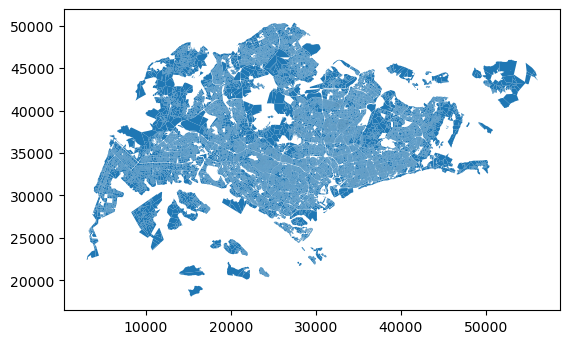

In [78]:
gdf.plot()

In [79]:
gdf.to_parquet(f"./out/{place}/tessellation_stats.pq")

: 

In [ ]:
# chunk_size = 250000
# chunks = []
# for i in range(0, len(tessellation), chunk_size):
#     chunks.append(tessellation.iloc[i:i + chunk_size])

In [ ]:
# import os
# new_directory = f"./out/{place}/tessellation/"

# if not os.path.exists(new_directory):
#     os.makedirs(new_directory)
#     print(f"Created directory: {new_directory}")
# else:
#     print(f"Directory already exists: {new_directory}")

# # iterate over all files in the directory and delete them
# for filename in os.listdir(new_directory):
#     file_path = os.path.join(new_directory, filename)
#     if os.path.isfile(file_path):
#         os.remove(file_path)
#         print(f"Deleted file: {file_path}")

In [ ]:
# for i, chunk in enumerate(chunks):
#     chunk.to_parquet(f"./out/{place}/tessellation/tesselation_chunk_{i}.pq")

In [ ]:
# duplicates = tessellation[tessellation.duplicated(['uID'], keep=False)]
# if len(duplicates) > 0:
#     print(f"There are {len(duplicates)} rows with duplicate uids.")
#     print(duplicates)
# else:
#     print("There are no rows with duplicate uids.")

In [ ]:
# import pickle

# # Open the file for reading
# with open('./out/{place}/weights.pickle', 'rb') as f:
#     # Load the variables in the same order that they were dumped
#     queen_1 = pickle.load(f)
#     queen_3 = pickle.load(f)
#     dist200 = pickle.load(f)
#     tessellation = pickle.load(f)

In [ ]:
# tessellation.to_parquet("./out/{place}/tessellation_with_data.pq", write_metadata_file=False)

In [ ]:
daskCluster.close()
client.shutdown()
